## This script is to convert recorded demonstrations (from rosbag format) to samples (in txt format) to conform with the TP-GMM code.

In [99]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sys import platform

# from franka_msgs.msg import FrankaState

print(platform)
if platform == "linux":
    main_dir = "/home/zizo/Disassembly Teleop/"
    TPGMM_dir = "/home/zizo/haptics-ctrl_ws/src/tp_gmm/data/"
elif platform == "win32":
    main_dir = "C:/Users/AWasf/OneDrive/Desktop/PhD Lab Work/Disassembly-Teleop/"
    TPGMM_dir = "C:/Users/AWasf/OneDrive/Desktop/PhD Lab Work/tp_gmm/data/"


linux


### Defining the directory according to the given task_name, and thus loop over the Demons in the directory (task_name, nbDemons in dir, ref_demon)

In [100]:
# Getting the task_name from tp-gmm.py
import pickle

with open('/home/zizo/haptics-ctrl_ws/src/tp_gmm/scripts/demons_info1.pkl', 'rb') as fp:
    demons_info = pickle.load(fp)
    print(demons_info)
task_name = demons_info['task_name']
print("task_name: ", task_name)

# 
import os

demons_names = []
demons_nums = []
for filename in os.listdir(main_dir + "Demons/" + task_name + "/action"):
    demons_names.append(filename)
    demons_nums.append(filename[filename.find('Demon'):filename.find('.bag')])

print(demons_names)
print(demons_nums)

nbdemons = len(demons_names)
print("Number of Demons: ", nbdemons)


{'task_name': 'Rbolts'}
task_name:  Rbolts
['Franka_Stage2_Rbolts_action_Demon_02_4_4.bag', 'Franka_Stage2_Rbolts_action_Demon_02_4_3.bag', 'Franka_Stage2_Rbolts_action_Demon_02_4_5.bag', 'Franka_Stage2_Rbolts_action_Demon_02_4_7.bag', 'Franka_Stage2_Rbolts_action_Demon_02_4_2.bag', 'Franka_Stage2_Rbolts_action_Demon_02_4_1.bag', 'Franka_Stage2_Rbolts_action_Demon_02_4_6.bag']
['Demon_02_4_4', 'Demon_02_4_3', 'Demon_02_4_5', 'Demon_02_4_7', 'Demon_02_4_2', 'Demon_02_4_1', 'Demon_02_4_6']
Number of Demons:  7


### 3D

In [101]:
ref_demon = {'ref':'', 'ref_nbpoints': 100000, 'nbDemons': nbdemons, 'demons_nums': demons_nums} # Choosing the shortest demon to be the reference in DTW
# ref_demon = {'ref':'', 'ref_nbpoints': 0, 'nbDemons': nbdemons, 'demons_nums': demons_nums} # Choosing the longest demon to be the reference in DTW

for d in range(nbdemons):
    # task_name = "Rcover"

    demon_bag = rosbag.Bag(main_dir + "Demons/" + task_name + "/action/" + demons_names[d], 'r')

    data_topic = "/panda_teleop/follower_state_controller/franka_states"

    dim = 1 + 3                        # jointstate tpgmm model
    conc_arr_Data = np.zeros((dim,1))
    conc_arr_Joints = np.zeros((1+7,1))# To record joint data for computing Jacobians
    # conc_arr_Data = np.zeros((dim,1))  # jointspace tpgmm model
    down_sample = 6 # Down sample factor to speed up the whole tpgmm node. 1 to sample all, higher decreases the number of points in trajectory
    msg_count = 0
    for topic, msg, t in demon_bag.read_messages(data_topic):
        if (msg_count % down_sample == 0):
            # Preparing the Data points matrix from the Demons
            # arr_Data = np.array([[sqrt(msg.O_T_EE_c[12]**2 + msg.O_T_EE_c[13]**2 + msg.O_T_EE_c[14]**2)], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) # Euc. distance of error_pose
            arr_Data = np.array([[msg.O_T_EE_c[0]], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) #, [msg.O_T_EE_c[3]], [msg.O_T_EE_c[7]], [msg.O_T_EE_c[11]], [msg.O_T_EE_c[15]]]) # time sample
            arr_Joints = np.array([[msg.O_T_EE_c[0]], [msg.q[0]], [msg.q[1]], [msg.q[2]], [msg.q[3]], [msg.q[4]], [msg.q[5]], [msg.q[6]]]) # time sample
            # arr_Data = np.array([[msg.O_T_EE_c[0]], [msg.q[0]],[msg.q[1]], [msg.q[2]], [msg.q[3]], [msg.q[4]], [msg.q[5]], [msg.q[6]]]) # time sample
            # print(arr_Data)
            conc_arr_Data = np.concatenate((conc_arr_Data, arr_Data), axis=1)
            conc_arr_Joints = np.concatenate((conc_arr_Joints, arr_Joints), axis=1)
            # Preparing the b matrix & A matrix for frame 1 (Position & RotationMatrix of the Starting point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
            if (msg_count == 0):
                arr_frame1_b = np.array([[0], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) #, [msg.O_T_EE_c[3]], [msg.O_T_EE_c[7]], [msg.O_T_EE_c[11]], [msg.O_T_EE_c[15]]])
                arr_frame1_A = np.matrix([[1,             0,             0,             0],
                                        [0, msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
                                        [0, msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
                                        [0, msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])
                # arr_frame1_A = np.block([ [arr_frame1_A, np.zeros((4,4))], [np.zeros((4,4)), np.zeros((4,4))] ])
                # jointspace tpgmm model
                # arr_frame1_b = np.array([[0], [msg.q[0]],[msg.q[1]], [msg.q[2]], [msg.q[3]], [msg.q[4]], [msg.q[5]], [msg.q[6]]])
                # arr_frame1_b = np.zeros((dim,1))
                # arr_frame1_A = np.identity(dim)

            # Preparing the b matrix & A matrix for frame 2 (Position & RotationMatrix of the Ending point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
            arr_frame2_b = np.array([[0], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) #, [msg.O_T_EE_c[3]], [msg.O_T_EE_c[7]], [msg.O_T_EE_c[11]], [msg.O_T_EE_c[15]]])
            arr_frame2_A = np.matrix([[1,             0,             0,             0],
                                    [0, msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
                                    [0, msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
                                    [0, msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])
            # arr_frame2_A = np.block([ [arr_frame2_A, np.zeros((4,4))], [np.zeros((4,4)), np.zeros((4,4))] ])
            # jointstate tpgmm model
            # arr_frame2_b = np.array([[0], [msg.q[0]],[msg.q[1]], [msg.q[2]], [msg.q[3]], [msg.q[4]], [msg.q[5]], [msg.q[6]]])
            # arr_frame2_b = np.zeros((dim,1))
            # arr_frame2_A = np.identity(dim)
        msg_count += 1
    demon_bag.close()
    print("Number of data points in {}: {}".format(demons_nums[d], conc_arr_Data.shape[1]-2)) #, msg_count))
    # Choosing the shortest Demon to be the reference Demon
    # if (msg_count < ref_demon['ref_nbpoints']):
    if (conc_arr_Data.shape[1]-2 < ref_demon['ref_nbpoints']):
        ref_demon["ref"] = demons_nums[d]
        ref_demon["ref_nbpoints"] = conc_arr_Data.shape[1]-2 # because the DTW reduces 1 point!! # msg_count
        ref_demon["down_sample_factor"] = down_sample
    # Choosing the longest Demon to be the reference Demon
    # if (msg_count > ref_demon['ref_nbpoints']):
    #     ref_demon["ref"] = demons_nums[d]
    #     ref_demon["ref_nbpoints"] = msg_count

    # Filling in b matrix & A matrix for frame 1
    conc_arr_frame1_b = np.ones((dim, msg_count)) * arr_frame1_b
    conc_arr_frame1_A = np.tile(arr_frame1_A, msg_count) # the .T is because the rotation is around negative y-axis

    # Filling in b matrix & A matrix for frame 2
    conc_arr_frame2_b = np.ones((dim, msg_count)) * arr_frame2_b
    conc_arr_frame2_A = np.tile(arr_frame2_A, msg_count)

    # Saving in txt files
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", conc_arr_Data[:,1:], fmt='%.5f') # cut out the 1st column (zeros) that was created only to initialize the array 
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_Joints.txt", conc_arr_Joints[:,1:], fmt='%.5f') # cut out the 1st column (zeros) that was created only to initialize the array 
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_b.txt", conc_arr_frame1_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_A.txt", conc_arr_frame1_A, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_b.txt", conc_arr_frame2_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_A.txt", conc_arr_frame2_A, fmt='%.5f')

    # Add the ',' to put file in the format that TP-GMM code accepts
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_Data.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_Joints.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_Joints.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_frame2_A.txt", 'w') as f:
        f.write(data)

print("Reference Demon:")
print(ref_demon)
with open('/home/zizo/haptics-ctrl_ws/src/tp_gmm/scripts/demons_info2.pkl', 'wb') as fp:
    pickle.dump(ref_demon, fp)

Number of data points in Demon_02_4_4: 1039
Number of data points in Demon_02_4_3: 696
Number of data points in Demon_02_4_5: 589
Number of data points in Demon_02_4_7: 318
Number of data points in Demon_02_4_2: 817
Number of data points in Demon_02_4_1: 201
Number of data points in Demon_02_4_6: 303
Reference Demon:
{'ref': 'Demon_02_4_1', 'ref_nbpoints': 201, 'nbDemons': 7, 'demons_nums': ['Demon_02_4_4', 'Demon_02_4_3', 'Demon_02_4_5', 'Demon_02_4_7', 'Demon_02_4_2', 'Demon_02_4_1', 'Demon_02_4_6'], 'down_sample_factor': 8}


### DTW the demons

Reference Demon:
(4, 202)
DTWinng..
(4, 1040)
(201,)
Debugging
(4, 201)


DTWinng..
(4, 697)
(201,)
Debugging
(4, 201)


DTWinng..
(4, 590)
(201,)
Debugging
(4, 201)


DTWinng..
(4, 319)
(201,)
Debugging
(4, 201)


DTWinng..
(4, 818)
(201,)
Debugging
(4, 201)


DTWinng..
(4, 202)
(201,)
Debugging
(4, 201)


DTWinng..
(4, 304)
(201,)
Debugging
(4, 201)




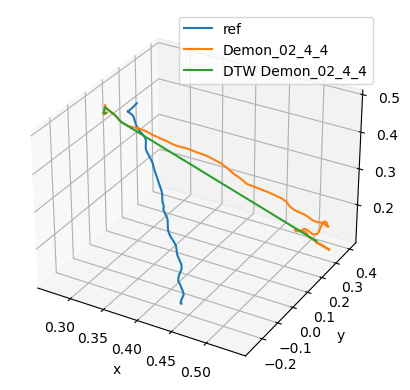

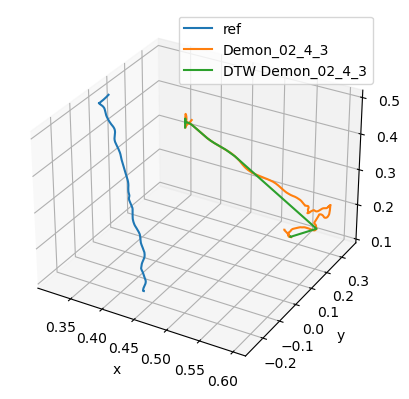

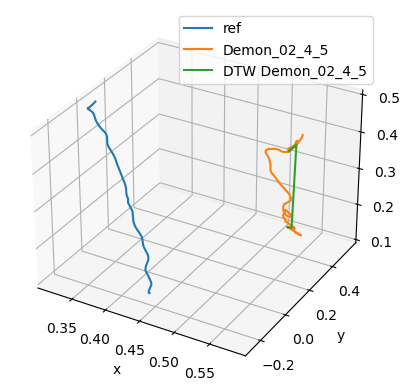

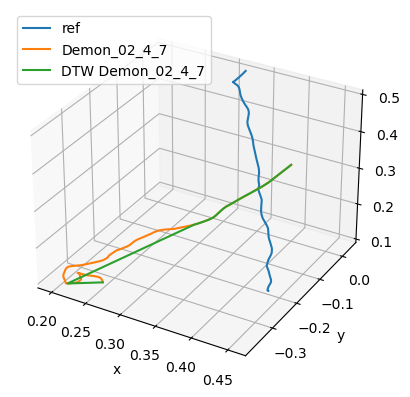

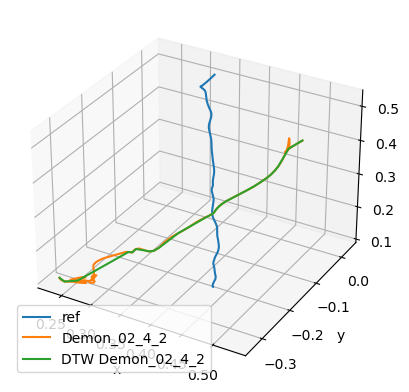

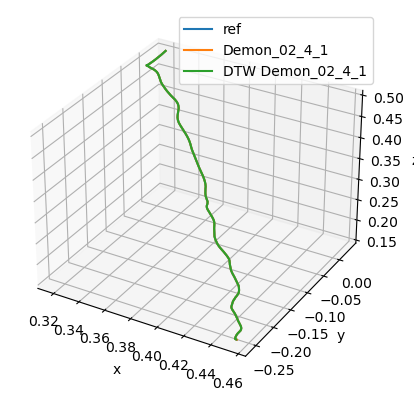

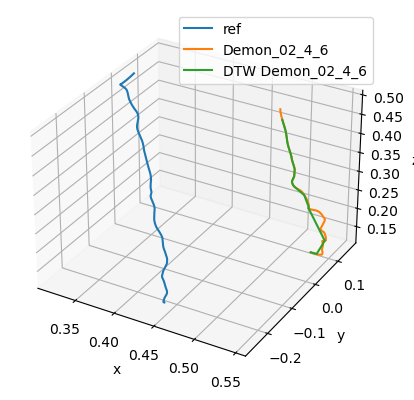

In [102]:
%matplotlib inline
# %matplotlib qt
from dtw import *

print("Reference Demon:")
ref_arr_Data = np.loadtxt(TPGMM_dir + ref_demon['ref'] + "_sample_Data.txt", delimiter=',')
print(ref_arr_Data.shape)

for d in range(nbdemons):
    
    print("DTWinng..")
    temp_arr_Data = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", delimiter=',')
    print(temp_arr_Data.shape)
    temp_arr_Joints = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_Joints.txt", delimiter=',')

    DTW = dtw(temp_arr_Data[1:,:].T, ref_arr_Data[1:,:].T)
    wq = warp(DTW, index_reference=False)
    print(wq.shape)

    ## Plotting
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot(ref_arr_Data[1,:], ref_arr_Data[2,:], ref_arr_Data[3,:], label='ref')
    ax.plot(temp_arr_Data[1,:], temp_arr_Data[2,:], temp_arr_Data[3,:], label='{}'.format(demons_nums[d]))
    ax.plot(temp_arr_Data[1,wq], temp_arr_Data[2,wq], temp_arr_Data[3,wq], label='DTW {}'.format(demons_nums[d]))
    
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ## Saving in .txt
    temp_arr_Data = temp_arr_Data[:,wq]
    temp_arr_Data[0,:] = ref_arr_Data[0,:ref_arr_Data.shape[1]-1] # To keep the time samples
    temp_arr_Joints = temp_arr_Joints[:,wq]
    
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", temp_arr_Data, fmt='%.5f')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_Data.txt", 'w') as f:
        f.write(data)

    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_Joints.txt", temp_arr_Joints, fmt='%.5f')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_Joints.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_Joints.txt", 'w') as f:
        f.write(data)

    # # Re-shaping the A & b matrices .txt to be of the same shape as the reference Demon (longest or shortest)
    # temp_arr_frame1_b = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_b.txt", delimiter=',')
    # temp_arr_frame1_A = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_A.txt", delimiter=',')
    # temp_arr_frame2_b = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_b.txt", delimiter=',')
    # temp_arr_frame2_A = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_A.txt", delimiter=',')
    
    # temp_arr_frame1_b = np.ones((ref_arr_Data.shape[0], ref_arr_Data.shape[1])) * temp_arr_frame1_b[:,0].reshape(ref_arr_Data.shape[0], 1)
    # temp_arr_frame1_A = np.tile(temp_arr_frame1_A[:4,:4], ref_arr_Data.shape[1])
    # temp_arr_frame2_b = np.ones((ref_arr_Data.shape[0], ref_arr_Data.shape[1])) * temp_arr_frame2_b[:,0].reshape(ref_arr_Data.shape[0], 1)
    # temp_arr_frame2_A = np.tile(temp_arr_frame2_A[:4,:4], ref_arr_Data.shape[1])

    # np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_b.txt", temp_arr_frame1_b, fmt='%.5f')
    # np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_A.txt", temp_arr_frame1_A, fmt='%.5f')
    # np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_b.txt", temp_arr_frame2_b, fmt='%.5f')
    # np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_A.txt", temp_arr_frame2_A, fmt='%.5f')

    # with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'r') as f:
    #     data = f.read(); data = data.replace(' ', ',')
    # with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'w') as f:
    #     f.write(data)

    # with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'r') as f:
    #     data = f.read(); data = data.replace(' ', ',')
    # with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'w') as f:
    #     f.write(data)

    # with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'r') as f:
    #     data = f.read(); data = data.replace(' ', ',')
    # with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'w') as f:
    #     f.write(data)

    # with open(r"{}".format(TPGMM_dir) + demons_nums[topic
    ## Only for debuggin to check the txt file shape
    print("Debugging")
    temp_arr_Data = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", delimiter=',')
    print(temp_arr_Data.shape)
    print("\n")
    


In [103]:
# print(temp_arr_frame1_b.shape)
# print(temp_arr_frame1_A.shape)
# print(temp_arr_frame2_b.shape)
# print(temp_arr_frame2_A.shape)
# print(temp_arr_frame2_A[:4,:4].shape)